# Sieć klasyfikująca irysy

## Importowanie i omówienie danych wejściowych

In [22]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data # wejścia
y = iris.target

### Jak prezentują sie dane na wykresie?

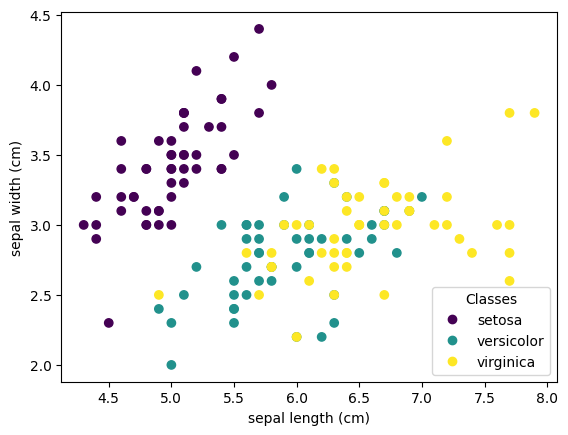

In [23]:
import matplotlib.pyplot as plt

_, ax = plt.subplots()
scatter = ax.scatter(iris.data[:, 0], iris.data[:, 1], c=iris.target)
ax.set(xlabel=iris.feature_names[0], ylabel=iris.feature_names[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

### Jakie informacje podajemy na wejściu?

In [24]:
feature_names = iris.feature_names
feature_names


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

### Jakie informacje otrzymujemy na wyjsciu?

In [25]:
terget_names = iris.target_names
terget_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

### Zmiana danych na format df

In [26]:
from pandas import DataFrame
df_X = DataFrame(X)

## Standaryzacja danych

### Dane przed standaryzacją

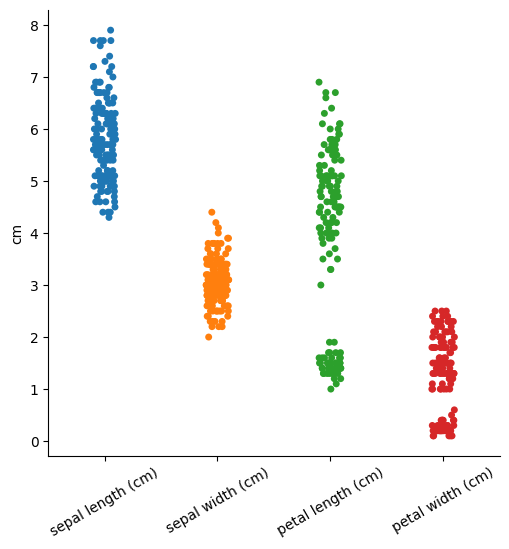

In [27]:
import seaborn as sns

sns.catplot(data=df_X).set_xticklabels(rotation = 30, labels=feature_names).set_ylabels('cm')

### Dane po standaryzacji (dane wycentrowane są w tym samym punkcie, wartość średnia jest równa 0. Istotne przy liczeniu gradientów)

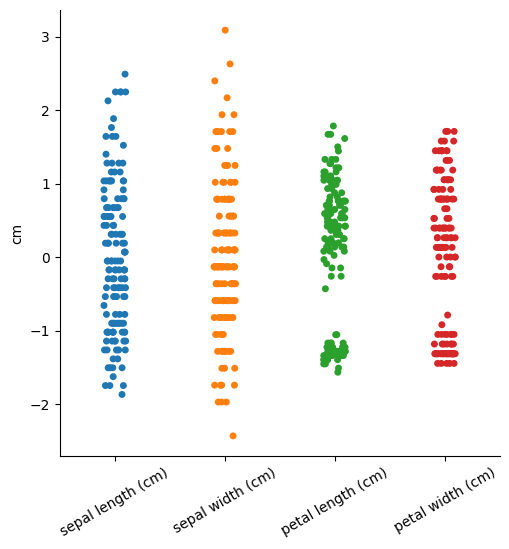

In [28]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

df_X_scaled = DataFrame(X_scaled)
sns.catplot(data=df_X_scaled).set_xticklabels(rotation = 30, labels=feature_names).set_ylabels("cm")

## Obróbka danych wyjściowych, one_hot_encoding klasyfikatora

In [34]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_onehot = encoder.fit_transform(y.reshape(-1,1))
y_onehot[1:10]


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

## Podział na dene treningowe i walidacyjne

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)
X_train[1:10]

array([[-0.17367395,  3.09077525, -1.2833891 , -1.05217993],
       [ 1.03800476,  0.09821729,  0.36489628,  0.26414192],
       [-1.26418478,  0.78880759, -1.22655167, -1.3154443 ],
       [-1.74885626,  0.32841405, -1.39706395, -1.3154443 ],
       [ 0.55333328, -1.28296331,  0.70592084,  0.92230284],
       [ 0.67450115,  0.32841405,  0.42173371,  0.3957741 ],
       [-0.7795133 ,  1.01900435, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.7795133 ,  2.40018495, -1.2833891 , -1.44707648]])

## Zmiana danych trenigowych i walidacyjnych na tensory biblioteki Pytorch

In [37]:
import torch

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)